In [212]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
import seaborn as sns
import sqlite3 as lite
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Data loading

We create a connection and load the data from the database

In [249]:
con = lite.connect('./data/src/diamonds_train.db/diamonds_train.db')

cursor = con.cursor()

raw_df = pd.read_sql('''SELECT *
FROM diamonds_transactional dt JOIN diamonds_dimensions ddi 
		ON dt.index_id = ddi.index_id 
	JOIN diamonds_properties dp ON dp.index_id = dt.index_id 
	JOIN diamonds_cut dc ON dc.cut_id = dp.cut_id 
	JOIN diamonds_color dc2 ON dc2.color_id = dp.color_id 
	JOIN diamonds_clarity dc3 ON dc3.clarity_id = dp.clarity_id 
	JOIN diamonds_city dc4 ON dc4.city_id = dt.city_id;''', con )

raw_df


,index_id,price,city_id,carat,index_id,depth,table,x,y,z,...,color_id,clarity_id,cut_id,cut,color_id,color,clarity_id,clarity,city_id,city
0,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,4268,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,1.21,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,62.4,58.0,6.83,6.79,4.25,...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,de88c121a82a06352bf1aaceba20578356408a334ba046...,Premium,6da43b944e494e885e69af021f93c6d9331c78aa228084...,J,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,VS2,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,Dubai
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,505,89c7286890f7347ab235234e74d406596a127ae3679042...,0.32,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,63.0,57.0,4.35,4.38,2.75,...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,Very Good,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,H,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,VS2,89c7286890f7347ab235234e74d406596a127ae3679042...,Kimberly
2,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,2686,2bd25cd960aba8b706e2b67f2bb38b750ee5384b0e9883...,0.71,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,65.5,55.0,5.62,5.53,3.65,...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,Fair,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,G,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,VS1,2bd25cd960aba8b706e2b67f2bb38b750ee5384b0e9883...,Las Vegas
3,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,738,89c7286890f7347ab235234e74d406596a127ae3679042...,0.41,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,63.8,56.0,4.68,4.72,3.00,...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,Good,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,D,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,SI1,89c7286890f7347ab235234e74d406596a127ae3679042...,Kimberly
4,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,4882,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,1.02,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,60.5,59.0,6.55,6.51,3.95,...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,Ideal,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,G,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,SI1,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,Dubai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,f0bc79169405ebeb24e308055156b946ffd819db9b4f75...,10070,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,1.34,f0bc79169405ebeb24e308055156b946ffd819db9b4f75...,62.7,57.0,7.10,7.04,4.43,...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,Ideal,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,G,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,VS1,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,Antwerp
40451,339916a23bf22b052b54cb2a9b36ee8418c1c68b46acad...,12615,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.02,339916a23bf22b052b54cb2a9b36ee8418c1c68b46acad...,57.1,60.0,8.31,8.25,4.73,...,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,Good,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,F,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,SI2,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,Madrid
40452,46957922b99954654c1deb8d854c3f069bf118b2ce9415...,5457,89c7286890f7347ab235234e74d406596a127ae3679042...,1.01,46957922b99954654c1deb8d854c3f069bf118b2ce9415...,62.7,56.0,6.37,6.42,

In [232]:
test = pd.read_csv('./data/src/diamonds_test.csv')
test['price'] = 0
submit_df = test[['id', 'price']]
test = test.drop(['id','price'], axis = 1)
test.head()

,carat,cut,color,clarity,depth,table,x,y,z,city
0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam
1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat
2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly
3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly
4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam


We select the usefull columns 

In [233]:
clean_df = raw_df[['price', 'carat',  'depth', 'table','x', 'y', 'z','cut', 'color', 'clarity', 'city']]
clean_df.to_csv('./data/clean/clean.csv')
clean_df

,price,carat,depth,table,x,y,z,cut,color,clarity,city
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,Dubai
1,505,0.32,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,Kimberly
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,Las Vegas
3,738,0.41,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,Kimberly
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,Dubai
...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,62.7,57.0,7.10,7.04,4.43,Ideal,G,VS1,Antwerp
40451,12615,2.02,57.1,60.0,8.31,8.25,4.73,Good,F,SI2,Madrid
40452,5457,1.01,62.7,56.0,6.37,6.42,4.01,Ideal,H,SI1,Kimberly
40453,456,0.33,61.9,54.3,4.45,4.47,2.76,Ideal,J,VS1,Kimberly


### EDA



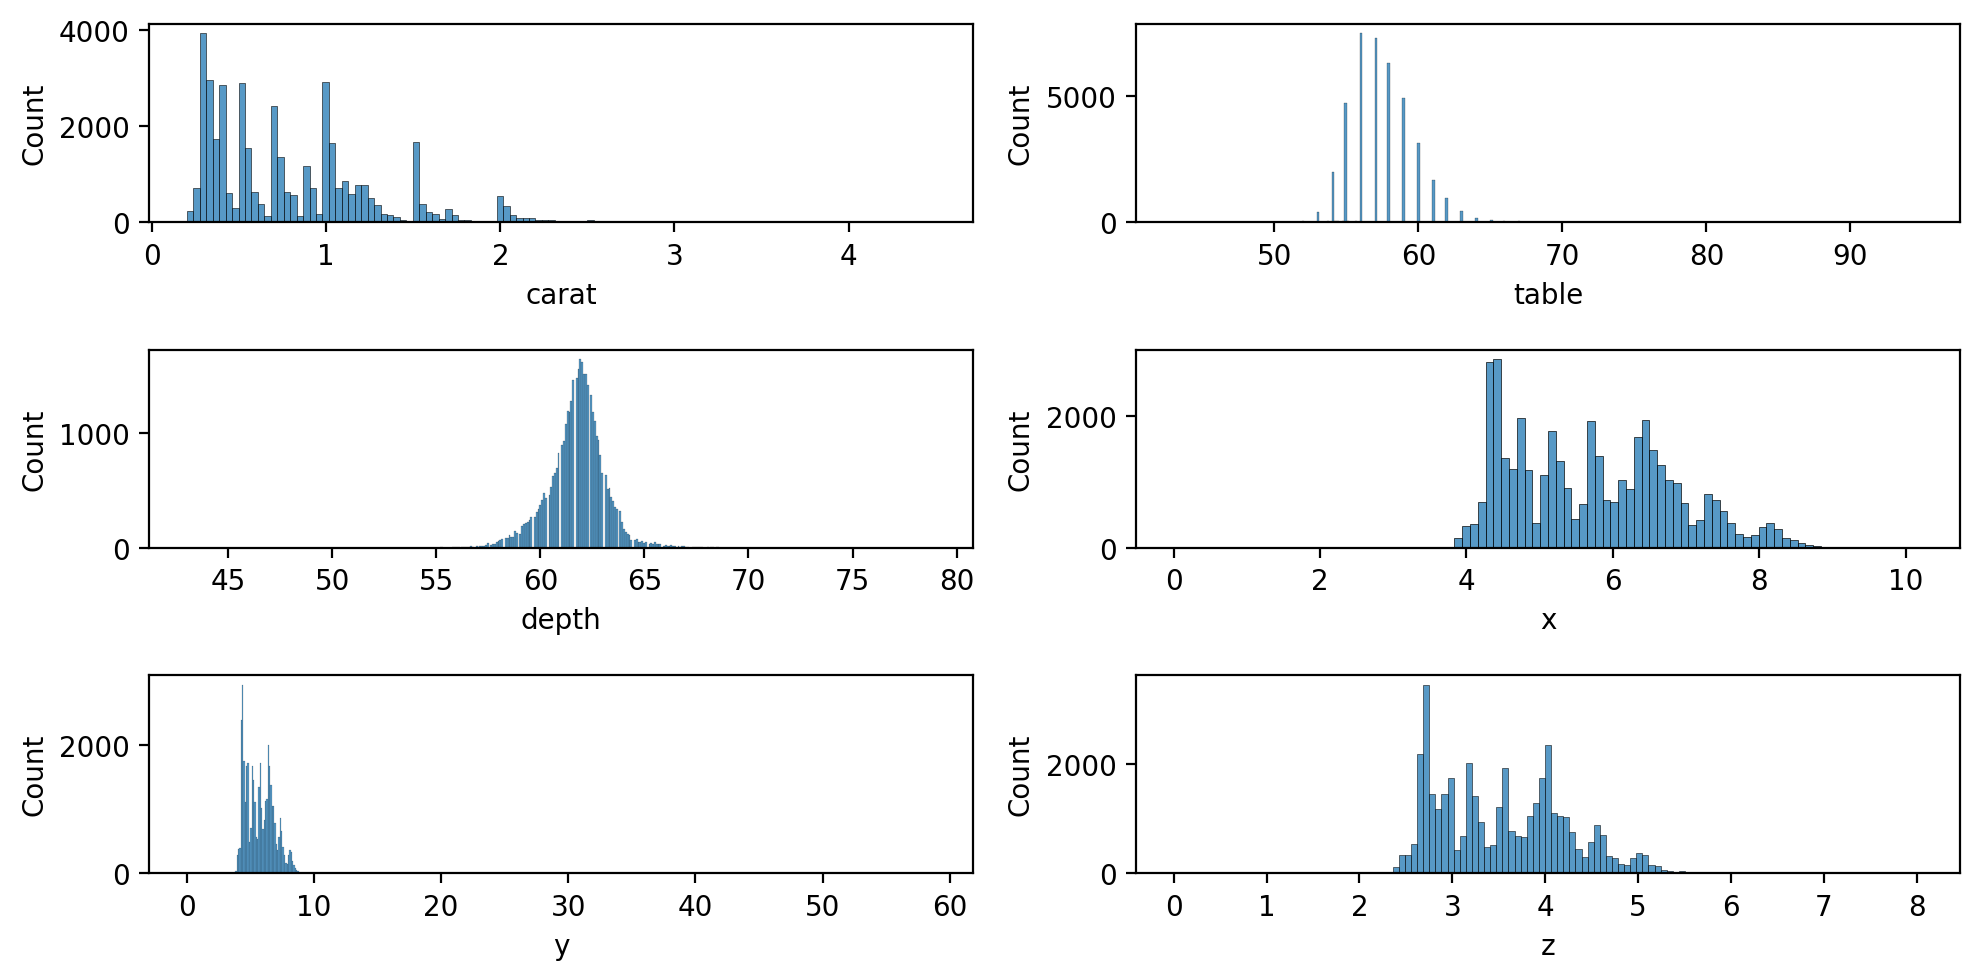

In [234]:
#Distribution of numerical features
fig, ax_arr = plt.subplots(3,2, figsize=(10,5),dpi=200)
sns.histplot(clean_df['carat'],ax = ax_arr[0][0])
sns.histplot(clean_df['table'],ax = ax_arr[0][1])
sns.histplot(clean_df['depth'],ax = ax_arr[1][0])
sns.histplot(clean_df['x'],ax = ax_arr[1][1])
sns.histplot(clean_df['y'],ax = ax_arr[2][0])
sns.histplot(clean_df['z'],ax = ax_arr[2][1])
plt.tight_layout()

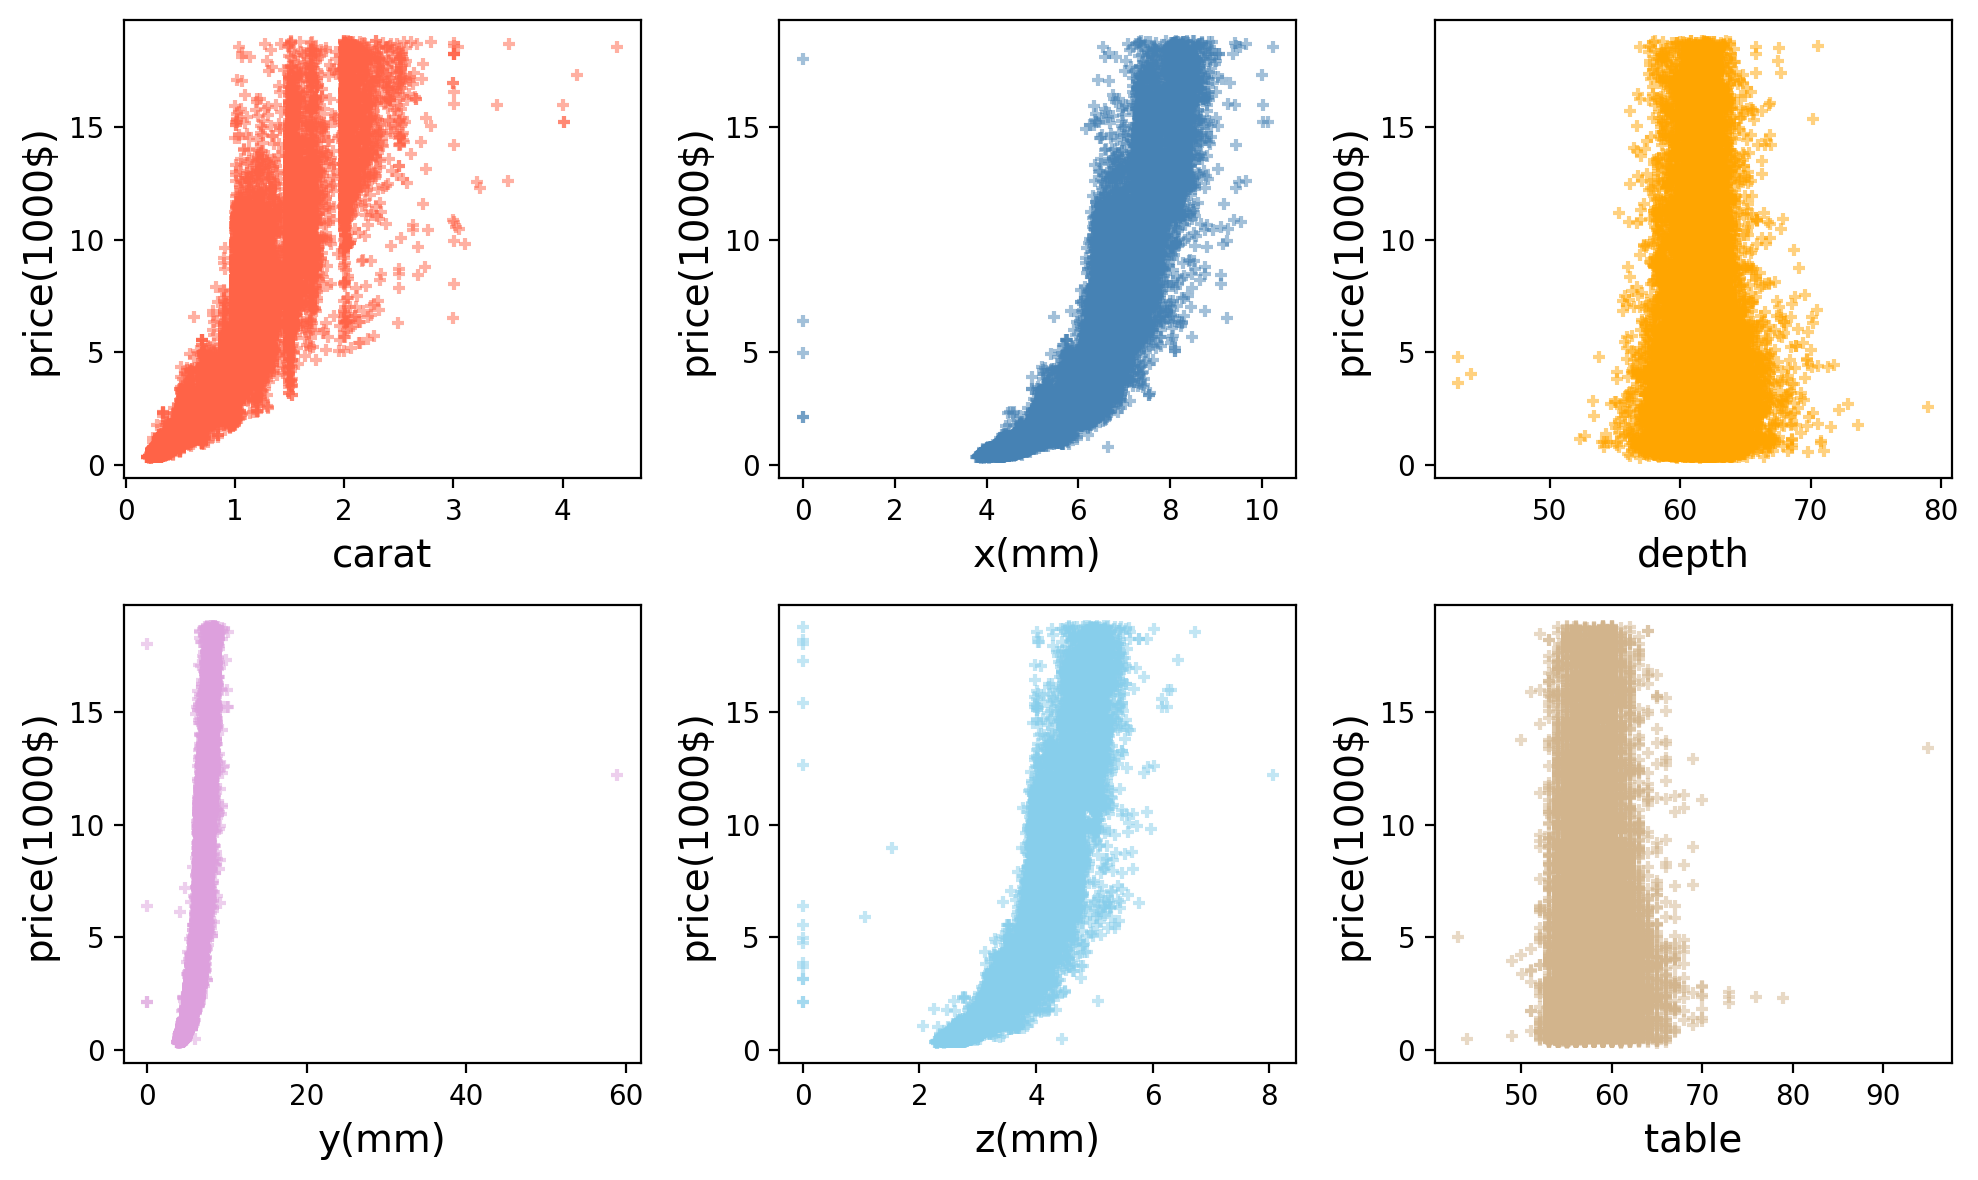

In [235]:
#Scatterplot of each numerical feature vs the target
fig, ax_arr = plt.subplots(2,3, figsize=(10,6),dpi=200)
ax1 = ax_arr[0][0]
ax1.scatter(clean_df['carat'],clean_df['price']/1000,marker='+',color='tomato',alpha=0.5,s=20)
ax1.set_xlabel('carat',size=14)
ax1.set_ylabel('price(1000$)',size=14)

ax2 = ax_arr[0][1]
ax2.scatter(clean_df['x'],clean_df['price']/1000,marker='+',color='steelblue',alpha=0.5,s=20)
ax2.set_xlabel('x(mm)',size=14)
ax2.set_ylabel('price(1000$)',size=14)

ax3 = ax_arr[1][0]
ax3.scatter(clean_df['y'],clean_df['price']/1000,marker='+',color='plum',alpha=0.5,s=20)
ax3.set_xlabel('y(mm)',size=14)
ax3.set_ylabel('price(1000$)',size=14)

ax4 = ax_arr[1][1]
ax4.scatter(clean_df['z'],clean_df['price']/1000,marker='+',color='skyblue',alpha=0.5,s=20)
ax4.set_xlabel('z(mm)',size=14)
ax4.set_ylabel('price(1000$)',size=14)

ax5 = ax_arr[0][2]
ax5.scatter(clean_df['depth'],clean_df['price']/1000,marker='+',color='orange',alpha=0.5,s=20)
ax5.set_xlabel('depth',size=14)
ax5.set_ylabel('price(1000$)',size=14)

ax6 = ax_arr[1][2]
ax6.scatter(clean_df['table'],clean_df['price']/1000,marker='+',color='tan',alpha=0.5,s=20)
ax6.set_xlabel('table',size=14)
ax6.set_ylabel('price(1000$)',size=14)

plt.tight_layout()

### Outlier Management

In [236]:
def sub_outlyers(df,deviations):
    df2 = df.copy()
    for col in df.columns:
        min = df[col].mean() - deviations * df[col].std()
        max = df[col].mean() + deviations * df[col].std()
        df2.loc[df[col] < min,col] = min    
        df2.loc[df[col] > max,col] = max
    return df2

In [237]:
outlier_columns = ['depth','table', 'x', 'y', 'z','carat']
clean_df[outlier_columns] = sub_outlyers(clean_df[outlier_columns],3.7)
test[outlier_columns] = sub_outlyers(test[outlier_columns],3.7)

C:\Users\rjcol\AppData\Local\Temp\ipykernel_19276\802708693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[outlier_columns] = sub_outlyers(clean_df[outlier_columns],3.7)


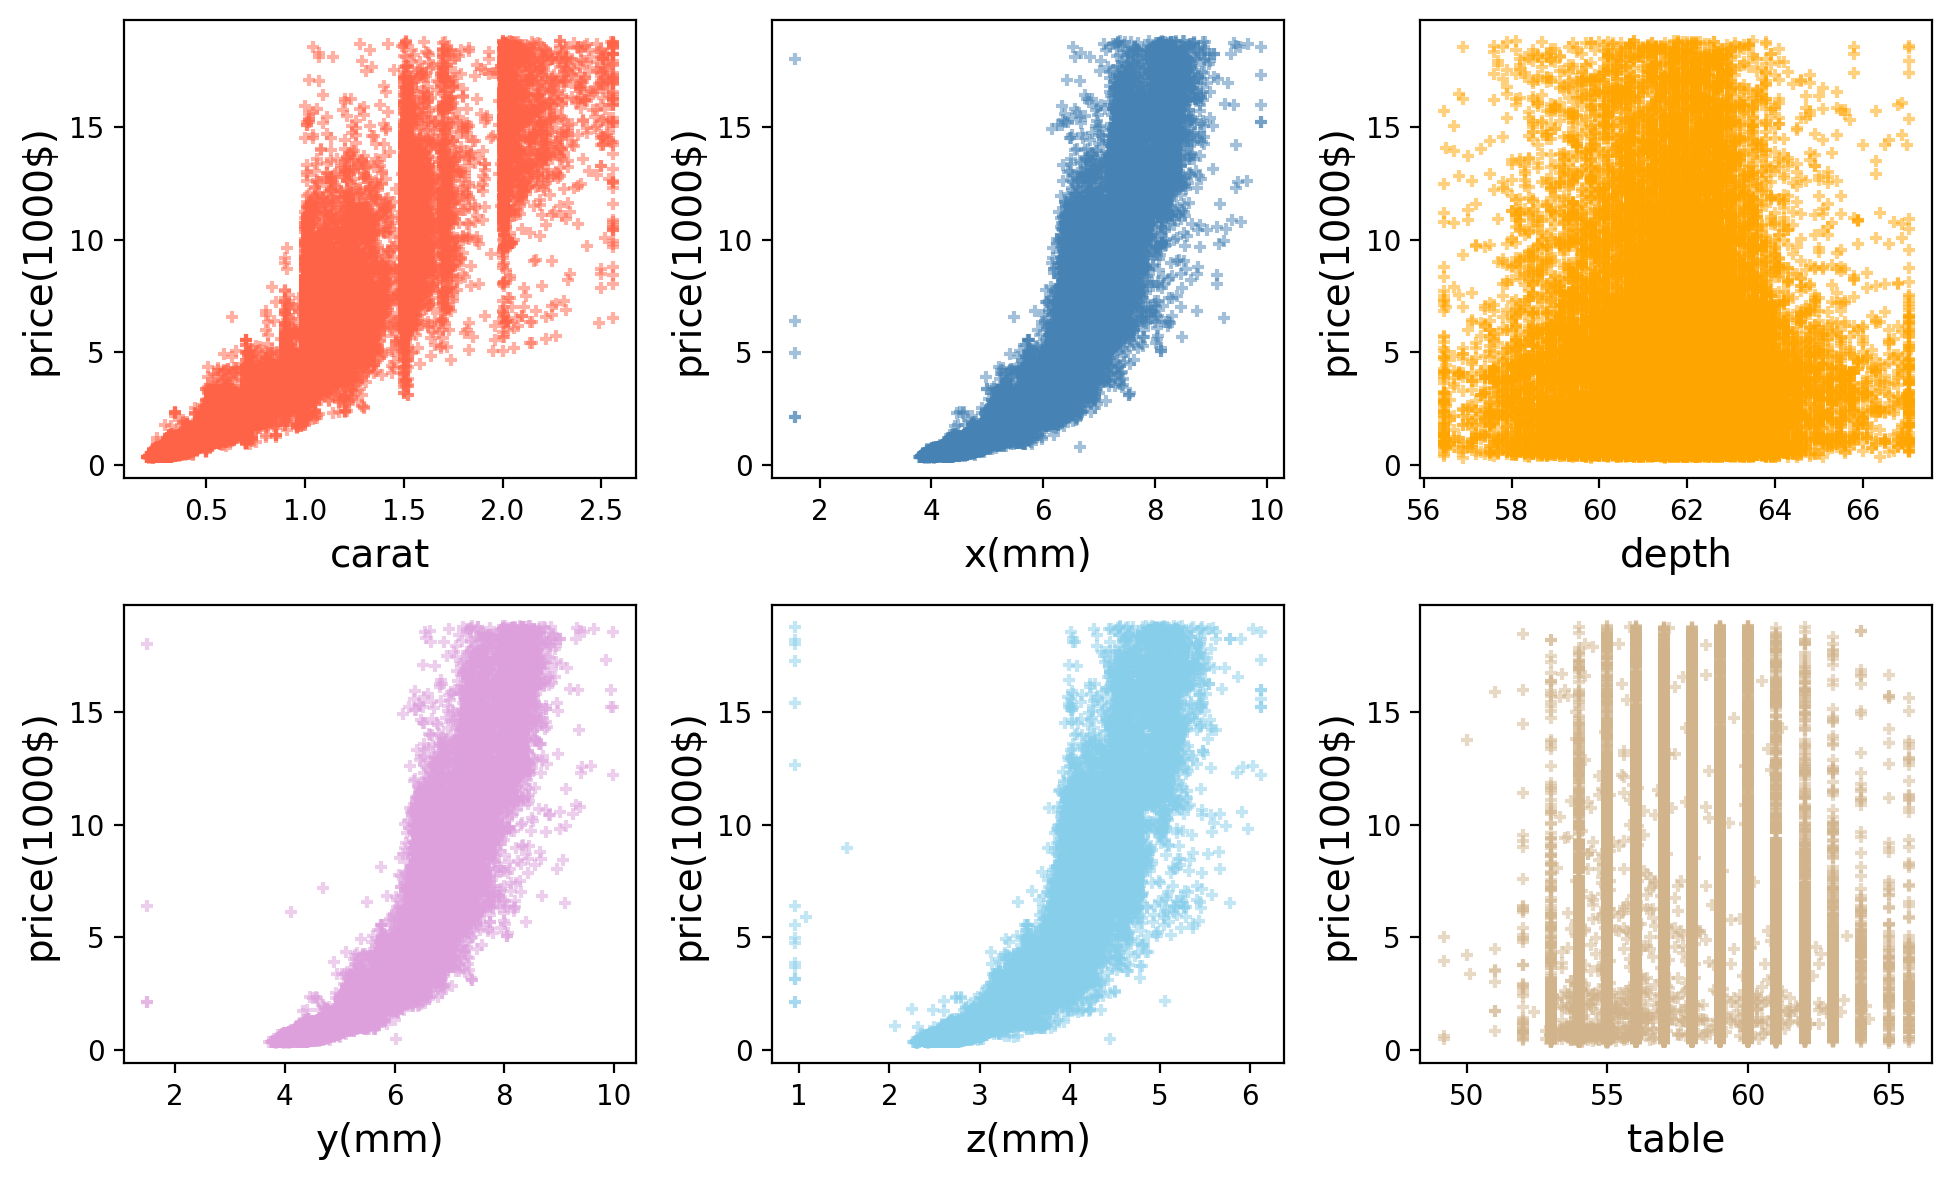

In [238]:
fig, ax_arr = plt.subplots(2,3, figsize=(10,6),dpi=200)
ax1 = ax_arr[0][0]
ax1.scatter(clean_df['carat'],clean_df['price']/1000,marker='+',color='tomato',alpha=0.5,s=20)
ax1.set_xlabel('carat',size=14)
ax1.set_ylabel('price(1000$)',size=14)

ax2 = ax_arr[0][1]
ax2.scatter(clean_df['x'],clean_df['price']/1000,marker='+',color='steelblue',alpha=0.5,s=20)
ax2.set_xlabel('x(mm)',size=14)
ax2.set_ylabel('price(1000$)',size=14)

ax3 = ax_arr[1][0]
ax3.scatter(clean_df['y'],clean_df['price']/1000,marker='+',color='plum',alpha=0.5,s=20)
ax3.set_xlabel('y(mm)',size=14)
ax3.set_ylabel('price(1000$)',size=14)

ax4 = ax_arr[1][1]
ax4.scatter(clean_df['z'],clean_df['price']/1000,marker='+',color='skyblue',alpha=0.5,s=20)
ax4.set_xlabel('z(mm)',size=14)
ax4.set_ylabel('price(1000$)',size=14)

ax5 = ax_arr[0][2]
ax5.scatter(clean_df['depth'],clean_df['price']/1000,marker='+',color='orange',alpha=0.5,s=20)
ax5.set_xlabel('depth',size=14)
ax5.set_ylabel('price(1000$)',size=14)

ax6 = ax_arr[1][2]
ax6.scatter(clean_df['table'],clean_df['price']/1000,marker='+',color='tan',alpha=0.5,s=20)
ax6.set_xlabel('table',size=14)
ax6.set_ylabel('price(1000$)',size=14)

plt.tight_layout()

### Label Encoding

In [239]:
def data_labeling(df, cols, dic):
   for col in cols:
      for key,value in dic.items():
         df.loc[df[col] == key,col] = value
      df[col] = df[col].astype(float)


As we expect a non linear relasionship between the price and the classes (ideal is not 5 times more expensive than fair) we asign the worst class a 1 and the rest the square root of their position.

In [240]:
dic = {'Ideal':np.sqrt(5),
 'Very Good': np.sqrt(3),
 'Good': np.sqrt(2),
 'Premium': np.sqrt(4),
 'Fair': 1,
 'E': np.sqrt(6),
 'D': np.sqrt(7),
 'G': np.sqrt(4),
 'F': np.sqrt(5),
 'H': np.sqrt(3),
 'I': np.sqrt(2),
 'J': 1,
 'IF': np.sqrt(8),
 'VVS1': np.sqrt(7),
 'VVS2': np.sqrt(6),
 'VS1': np.sqrt(5),
 'VS2': np.sqrt(4),
 'SI1': np.sqrt(3),
 'I1': 1,
 'SI2': np.sqrt(2),
 'Paris': 1.0,
 'Luxembourg': 1.0017263703064307,
 'Tel Aviv': 1.0051791109192922,
 'Zurich': 1.0310746655157532,
 'London': 1.0332326283987916,
 'Antwerp': 1.0358221838584376,
 'Madrid': 1.0360379801467414,
 'Las Vegas': 1.0388433318946915,
 'Surat': 1.0401381096245144,
 'New York City': 1.048769961156668,
 'Amsterdam': 1.0548122572291756,
 'Kimberly': 1.0561070349589987,
 'Dubai': 1.0699179974104445}

In [241]:
data_labeling(clean_df, ['cut', 'color', 'clarity','city'],dic)
data_labeling(test, ['cut', 'color', 'clarity','city'],dic)



C:\Users\rjcol\AppData\Local\Temp\ipykernel_19276\1948180533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
C:\Users\rjcol\AppData\Local\Temp\ipykernel_19276\1948180533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
C:\Users\rjcol\AppData\Local\Temp\ipykernel_19276\1948180533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

### Feature engineering

In [242]:
def feature_xy(x,y):
    try:
        return x/y
    except:
        return 0.999
    
def feature_ad(carat,x,y,z,):
    try:
        return carat/(x*y*z)
    except:
        return 0.006135


We add all the features that appear to have some meaning. For features that have synergy between them, we multiply them. Also, we creaye x/y proportion as it significantly impacts the price of the diamond

In [243]:
clean_df['x/y'] = (clean_df.apply(lambda x : feature_xy(x['x'], x['y']), axis=1))**12
clean_df['td'] = clean_df.apply(lambda x : feature_xy(x['table'], x['depth']), axis=1)
clean_df['ad'] = clean_df.apply(lambda x : feature_ad(x['carat'],x['x'], x['y'], x['z']), axis=1)
clean_df['cc'] = clean_df['carat'] * clean_df['clarity']
clean_df['colcut'] = clean_df['color'] * clean_df['cut']
clean_df['colcla'] = clean_df['color'] * clean_df['clarity']
clean_df['ccc'] = clean_df['color'] * clean_df['clarity'] * clean_df['cut']

test['x/y'] = (test.apply(lambda x : feature_xy(x['x'], x['y']), axis=1))**12
test['td'] = test.apply(lambda x : feature_xy(x['table'], x['depth']), axis=1)
test['ad'] = test.apply(lambda x : feature_ad(x['carat'],x['x'], x['y'], x['z']), axis=1)
test['cc'] = test['carat'] * test['clarity']
test['colcut'] = test['color'] * test['cut']
test['colcla'] = test['color'] * test['clarity']
test['ccc'] = test['color'] * test['clarity'] * test['cut']

C:\Users\rjcol\AppData\Local\Temp\ipykernel_19276\4250963351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['x/y'] = (clean_df.apply(lambda x : feature_xy(x['x'], x['y']), axis=1))**12
C:\Users\rjcol\AppData\Local\Temp\ipykernel_19276\4250963351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['td'] = clean_df.apply(lambda x : feature_xy(x['table'], x['depth']), axis=1)
C:\Users\rjcol\AppData\Local\Temp\ipykernel_19276\4250963351.py:3: SettingWithCopyWarning: 
A value is trying to 

Removing the outliers of the new columns

In [244]:
clean_df[['td','ad']] = sub_outlyers(clean_df[['td','ad']],3.7)
test[['td','ad']] = sub_outlyers(test[['td','ad']],3.7)
clean_df.describe()

C:\Users\rjcol\AppData\Local\Temp\ipykernel_19276\669151293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[['td','ad']] = sub_outlyers(clean_df[['td','ad']],3.7)


,price,carat,depth,table,x,y,z,cut,color,clarity,city,x/y,td,ad,cc,colcut,colcla,ccc
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,4.045500e+04,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.797105,61.750399,57.440964,5.729562,5.731749,3.537448,1.951286,2.051004,1.970241,1.036433,1.012187e+00,0.930839,0.006135,1.499713,4.006021,4.040234,7.941814
std,3992.416147,0.472775,1.390932,2.202605,1.123510,1.115275,0.695006,0.311877,0.440629,0.409322,0.019357,1.767297e+00,0.046798,0.000459,0.838672,1.087280,1.199491,2.826062
min,326.000000,0.200000,56.455457,49.182052,1.568917,1.490214,0.958026,1.000000,1.000000,1.000000,1.000000,3.139806e-08,0.759091,0.002847,0.282843,1.000000,1.000000,1.000000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,1.732051,1.732051,1.732051,1.031075,9.147960e-01,0.898876,0.006047,0.827345,3.162278,3.162278,6.000000
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2.000000,2.000000,2.000000,1.038843,9.500106e-01,0.923825,0.006117,1.272792,4.000000,4.000000,7.745967
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000,2.236068,2.449490,2.236068,1.048770,1.086383e+00,0.955519,0.006190,1.991858,4.898979,4.898979,10.000000
max,18823.000000,2.557219,67.050225,65.710213,9.889867,9.975423,6.116282,2.236068,2.645751,2.828427,1.069918,3.161659e+02,1.105638,0.028417,6.477098,5.916080,7.483315,16.733201


In [245]:
test.describe()

,carat,cut,color,clarity,depth,table,x,y,z,city,x/y,td,ad,cc,colcut,colcla,ccc
count,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000
mean,0.797977,1.950833,2.056257,1.972234,61.737420,57.485837,5.736748,5.738326,3.541764,1.036266,1.022101,0.931788,0.006136,1.508139,4.013250,4.050978,7.954025
std,0.466108,0.310318,0.439013,0.407702,1.394992,2.217319,1.111809,1.104802,0.688296,0.019340,2.447549,0.047307,0.000566,0.841619,1.077714,1.186465,2.791160
min,0.200000,1.000000,1.000000,1.000000,56.428450,51.000000,1.615873,1.564171,0.838757,1.000000,0.000386,0.790458,0.001951,0.320000,1.000000,1.000000,1.000000
25%,0.400000,1.732051,1.732051,1.732051,61.000000,56.000000,4.730000,4.730000,2.920000,1.031075,0.915486,0.899054,0.006049,0.846640,3.162278,3.162278,6.000000
50%,0.700000,2.000000,2.000000,2.000000,61.900000,57.000000,5.700000,5.720000,3.530000,1.036038,0.950526,0.924092,0.006117,1.281718,4.000000,4.000000,7.745967
75%,1.040000,2.236068,2.449490,2.236068,62.500000,59.000000,6.530000,6.530000,4.040000,1.048770,1.087379,0.957096,0.006190,1.959592,4.898979,4.898979,10.000000
max,2.535419,2.236068,2.645751,2.828427,67.049740,65.767642,9.857035,9.915125,6.248191,1.069918,284.476904,1.108233,0.039120,6.477098,5.916080,7.483315,16.733201


we save the preprocessed datasets

In [246]:
test = test[clean_df.drop(['price'], axis=1).columns]
clean_df.to_csv('./data/clean/diamondsdl3feallcso3_7x2.csv')
test.to_csv('./data/clean/testdl3feallcso3_7x2.csv')

### Model testing

In [228]:
X= clean_df.drop('price', axis=1)
y = clean_df['price']

In [229]:

# Define the XGBoost regressor
xgb_model = XGBRegressor( missing=np.inf, enable_categorical=True)

# Optimal gridsearch with data labeling


param_grid_broad ={'colsample_bytree': [0.62],
                    'learning_rate': [0.0062,0.0065,0.0067],
                      'max_depth': [7],
                        'n_estimators': [2050,2100,2150],
                          'subsample': [0.95],
                            'gamma' :[0],
                              'missing': [np.inf]} 
param_grid_fine ={'colsample_bytree': [0.68,0.76,0.82],
                    'learning_rate': [ 0.0126,0.013],
                      'max_depth': [7],
                        'n_estimators': [1130,1140,1150],
                          'subsample': [0.95],
                            'gamma' :[0],
                              'missing': [np.inf]} 

'\n# Initialize RFE with XGBoost model\nrfe = RFE(estimator=xgb_model, n_features_to_select=len(X.columns)-1)\n\n# Fit RFE to training data\nrfe.fit(X_train, y_train)\n\n# Get selected features\nselected_features = X_train.columns[rfe.support_]\nselected_features'

In [230]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator= xgb_model, param_grid=param_grid_broad, cv=5, n_jobs=-1, verbose=3, scoring='neg_root_mean_squared_error')

# Fit the GridSearchCV instance to the training data
grid_search.fit(X, y)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best score found: ", best_score)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'colsample_bytree': 0.62, 'gamma': 0, 'learning_rate': 0.0065, 'max_depth': 7, 'missing': inf, 'n_estimators': 2100, 'subsample': 0.95}
Best score found:  -506.54783531855793


<Figure size 1000x600 with 0 Axes>

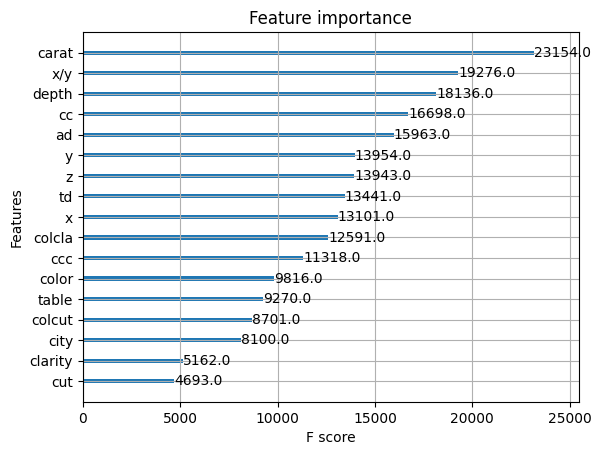

In [207]:
plt.figure(figsize=(10, 6))
ax = plot_importance(best_model, max_num_features=len(X.columns)+2)
plt.show()

### Predictions

In [208]:
price_list = best_model.predict(test)
submit_df['price'] = price_list
submit_df['price']

0        2887.423828
1        5443.897949
2        9392.466797
3        4009.408203
4        1609.634277
            ...     
13480    1696.805542
13481    2467.150146
13482    3006.683594
13483    2154.462158
13484     818.538147
Name: price, Length: 13485, dtype: float32

In [210]:
submit_df.set_index('id')['price'].to_csv('./submissions/xgbroadl3gfeallcso3.7x2_506.csv')

In [211]:
pickle.dump(best_model, open('./models/xgbroaddl3gfeallcso3.7x2_506.sav', 'wb'))